# **Fraud Detection Using Supervised Learning**
#### DTSA 5509 - Introduction to Machine Learning: Supervised Learning - Final Project ####
<hr>
<hr>

> **1. Project Overview**
> 
> **2. Project Setup**
>
> **3. Exploratory Data Analysis (EDA)**
>
> **4. Feature Selection**
>
> **5. Feature Engineering**
>
> **6. Classification Models**
>
>>
>> *6.1 Logistic Regression*
>>
>> *6.2 Decision Tree*
>>
>> *6.3 Random Forest*
>>
>> *6.4 Naive Bayes*
>>
>> *6.5 Support Vector Machines (SVM)*
>>
> **7. Classification Performance**
>
> **8. Area Under the Precision-Recall Curve (AUPRC)**
>
> **9. Results and Conclusion**

## **1) Project Overview**

### *About the Data:* ###
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, with 492 cases of frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The dataset contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, neither the original features nor more background information about the data can be provided. Features `V1`, `V2`, … `V28` are the principal components obtained with PCA. 

The only features which have not been transformed with PCA are `Time` and `Amount`. Feature `Time` contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature `Amount` is the transaction amount – this feature can be used for example-dependent cost-sensitive learning. Feature `Class` is the response variable which takes value 1 in case of fraud and 0 otherwise.

### *Objective:* ###
Find the most accurate supervised learning model for classifying fradulent credit card transcations.

*Based on [this Kaggle dataset.](https://www.kaggle.com/datasets/whenamancodes/fraud-detection?datasetId=2472961&sortBy=voteCount)*
<hr>

## **2) Project Setup**

In [1]:
# SUPPRESS WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [2]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve

In [3]:
# SET NOTEBOOK OPTIONS
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]
np.random.seed(31415)

In [4]:
# READ IN DATA
data = pd.read_csv('/kaggle/input/dtsa-5509-final-project/creditcard.csv')

<hr>

## **3. Exploratory Data Analysis (EDA)**
<hr>

In [5]:
# Preview data
display(data)

# Check data types
data.dtypes

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

All variables are the correct data type.<br>
30 numerical features and 1 boolean variable (`Class`).

In [6]:
# Check for missing values
any(data.isnull().sum())

False

No missing values.

In [7]:
# Check for blank values
np.where(data.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

No blank values.

In [8]:
# Count frequency of 'Class' labels
# 0 = Not Fraud; 1 = Fraud
print('Non-Fraudulent Transactions:', len(data[data['Class'] == 0]))
print('Fraudulent Transactions:', len(data[data['Class'] == 1]))

Non-Fraudulent Transactions: 284315
Fraudulent Transactions: 492


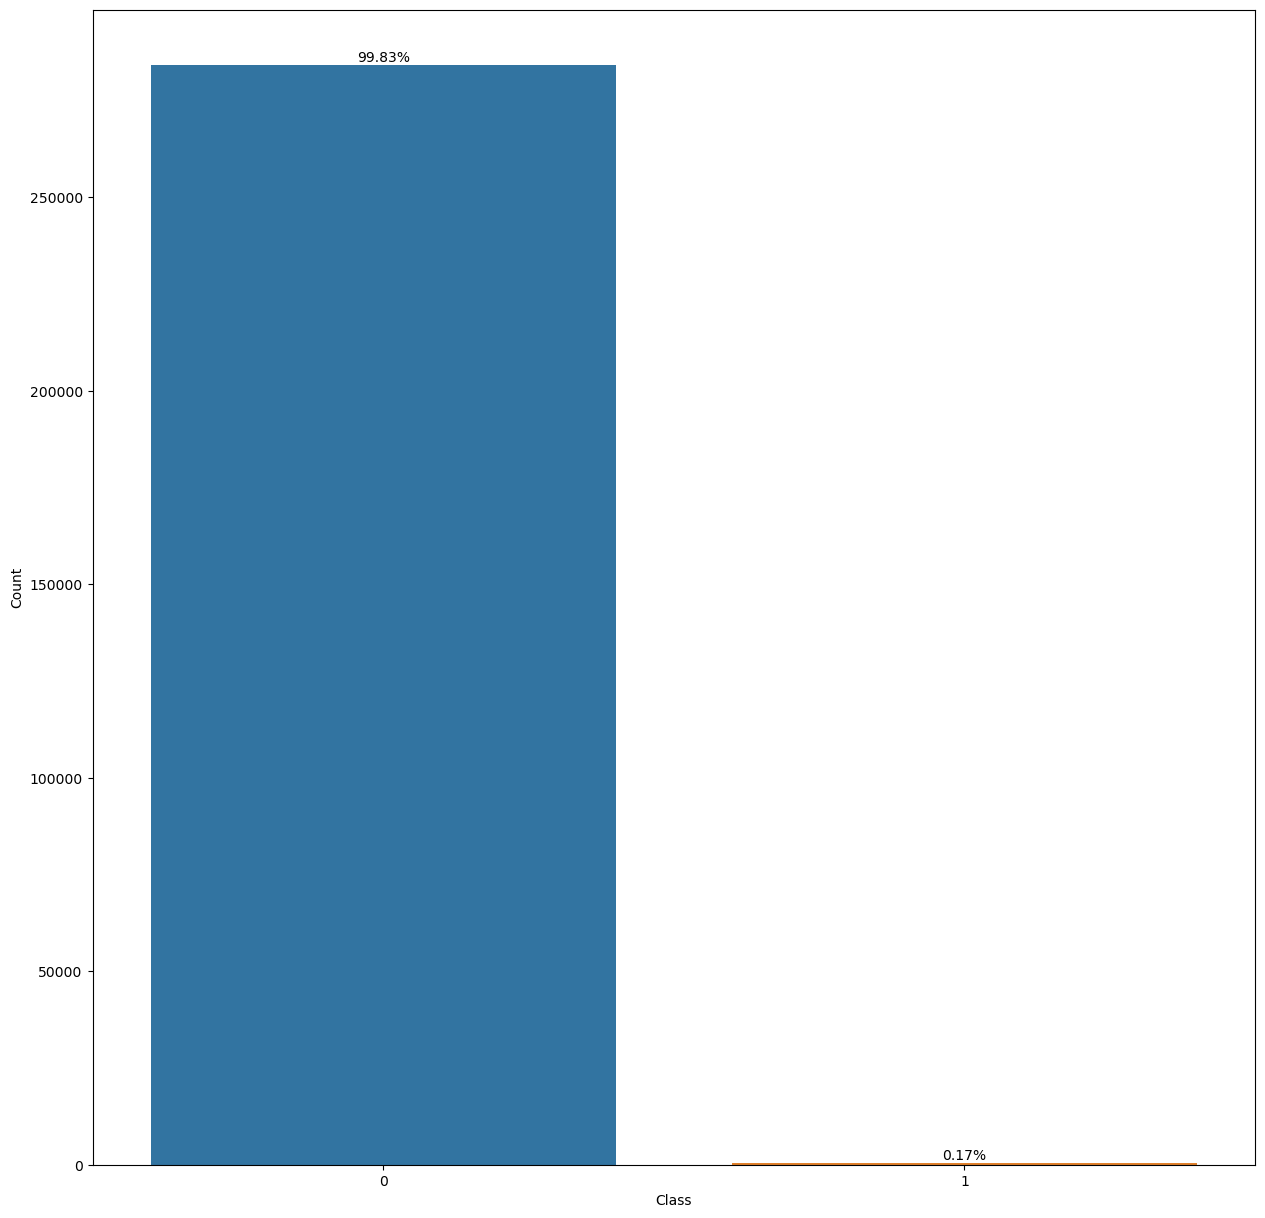

In [9]:
# 'Class' labels countplot with percentages
total = data.Class.count() # total count

ax = sns.countplot(x='Class', data=data)
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.2f}%')
ax.set(xlabel = 'Class', ylabel = 'Count')
plt.show()

Only 0.17% of the data is fraud data.

## **4. Feature Selection**
<hr>

### Outlier Detection
<hr>

Reduce the number of features by selecting the most important features using the interquartile range (IQR)| method for outlier detection.<br>
Features with a greater number of outliers that are also labelled as fraud *(`Class` = 1)* will be selected for the classification algorithms.
<hr>

In [10]:
# IQR outlier detection function
def detect_outliers(df):
    
    out_data = pd.DataFrame().reindex_like(df)
    out_data = out_data.fillna(0)

    df = df.apply(zscore)

    features = list(df.columns.values)
    n_features = len(features)

    for col in range(n_features):
        feature = df[features[col]]
        q1 = np.percentile(feature, 25) # 1st quartile (25%)
        q3 = np.percentile(feature, 75) # 3rd quartile (75%)
        iqr = q3 - q1 # IQR

        # Outlier Bounds
        lower = (q1 - 1.5 * iqr)
        upper = (q3 + 1.5 * iqr)
        
        # Consider any data point LESS than lower bound or GREATER than upper bound as an outlier
        outlier_index = df[(df[features[col]] < lower) | (df[features[col]] > upper)].index # list of outlier indices for every features 
        out_data.loc[outlier_index, features[col]] = 1 # mark outlier values as 1, otherwise 0
    
    return out_data

In [11]:
# Feature dataframe
features = [col for col in data if col.startswith('V')] # select feature variables only
feature_data = data[features]
feature_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533


In [12]:
# Apply IQR outlier detection function
out_data = detect_outliers(feature_data)
out_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
284803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284804,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Get indices of rows labelled as fraud
idx = data[data['Class']==1].index

# Count number of fraud outliers for each feature
out_count = out_data.iloc[idx,:].sum().sort_values()
out_count = pd.DataFrame(data=out_count).T

out_count

,V24,V13,V26,V15,V22,V25,V19,V6,V23,V1,...,V11,V7,V3,V4,V27,V16,V17,V10,V12,V14
0,3.0,8.0,10.0,12.0,28.0,55.0,135.0,137.0,149.0,174.0,...,294.0,301.0,312.0,318.0,344.0,351.0,397.0,399.0,409.0,430.0


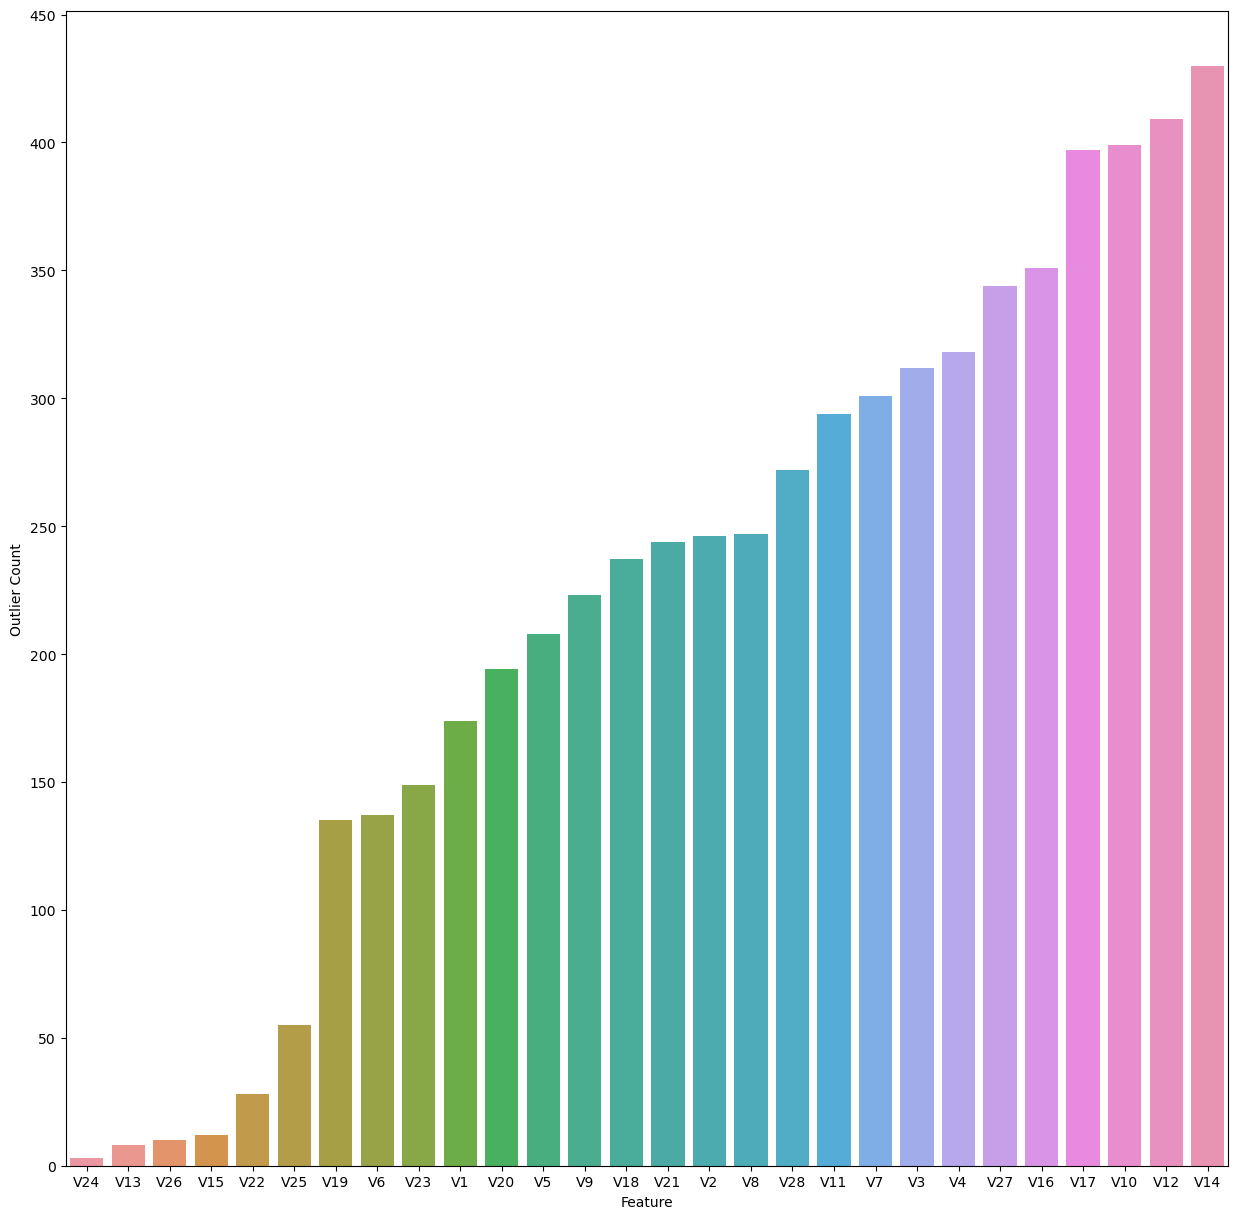

In [14]:
sns.barplot(out_count).set(xlabel='Feature', ylabel='Outlier Count')
plt.yticks(np.arange(0, 500, 50))
plt.show()

In [15]:
# Get Q3 (75th percentile) of outlier counts for feature selection
round(np.percentile(out_count, 75))

314

In [16]:
# Select features where number of outliers is greater than 314
selected_features = out_count.columns[out_count.loc[0].gt(314)].tolist()

selected_data = data[selected_features]
selected_data['Class'] = data['Class'] # add in 'Class' variable
selected_data

,V4,V27,V16,V17,V10,V12,V14,Class
0,1.378155,0.133558,-0.470401,0.207971,0.090794,-0.617801,-0.311169,0
1,0.448154,-0.008983,0.463917,-0.114805,-0.166974,1.065235,-0.143772,0
2,0.379780,-0.055353,-2.890083,1.109969,0.207643,0.066084,-0.165946,0
3,-0.863291,0.062723,-1.059647,-0.684093,-0.054952,0.178228,-0.287924,0
4,0.403034,0.219422,-0.451449,-0.237033,0.753074,0.538196,-1.119670,0
...,...,...,...,...,...,...,...,...
284802,-2.066656,0.943651,1.107641,1.991691,4.356170,2.711941,4.626942,0
284803,-0.738589,0.068472,-0.711757,-0.025693,-0.975926,0.915802,-0.675143,0
284804,-0.557828,0.004455,0.140716,0.313502,-0.484782,0.063119,-0.510602,0
284805,0.689799,0.108821,-0.608577,0.509928,-0.399126,-0.962886,0.449624,0


### Feature Plots
<hr>

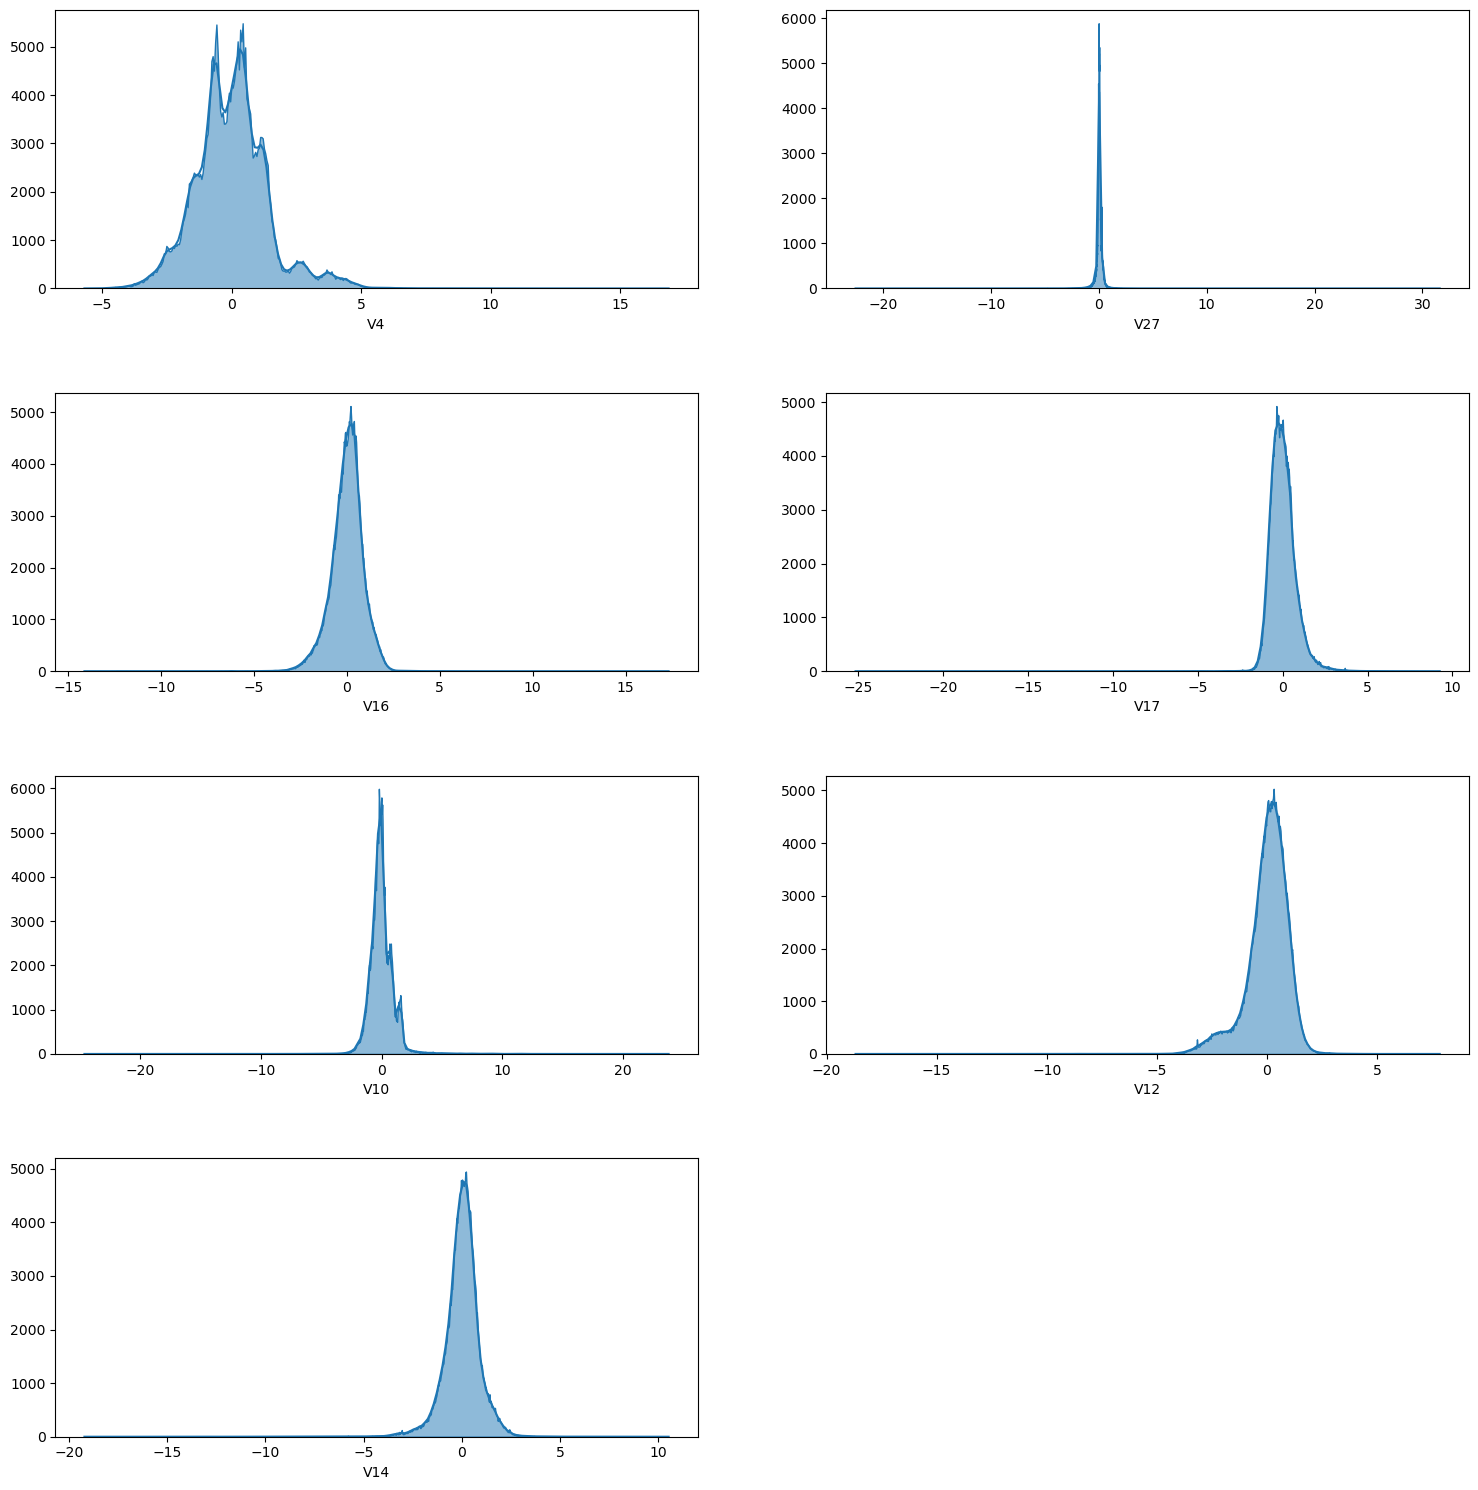

In [17]:
# Distribution plots
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
ax = axes.flatten()

for i, col in enumerate(selected_features):
    sns.histplot(selected_data[col], ax=ax[i], kde=True, element='poly').set_ylabel('', labelpad=0)
fig.tight_layout(w_pad=6, h_pad=4)
fig.delaxes(ax[7])
plt.show()

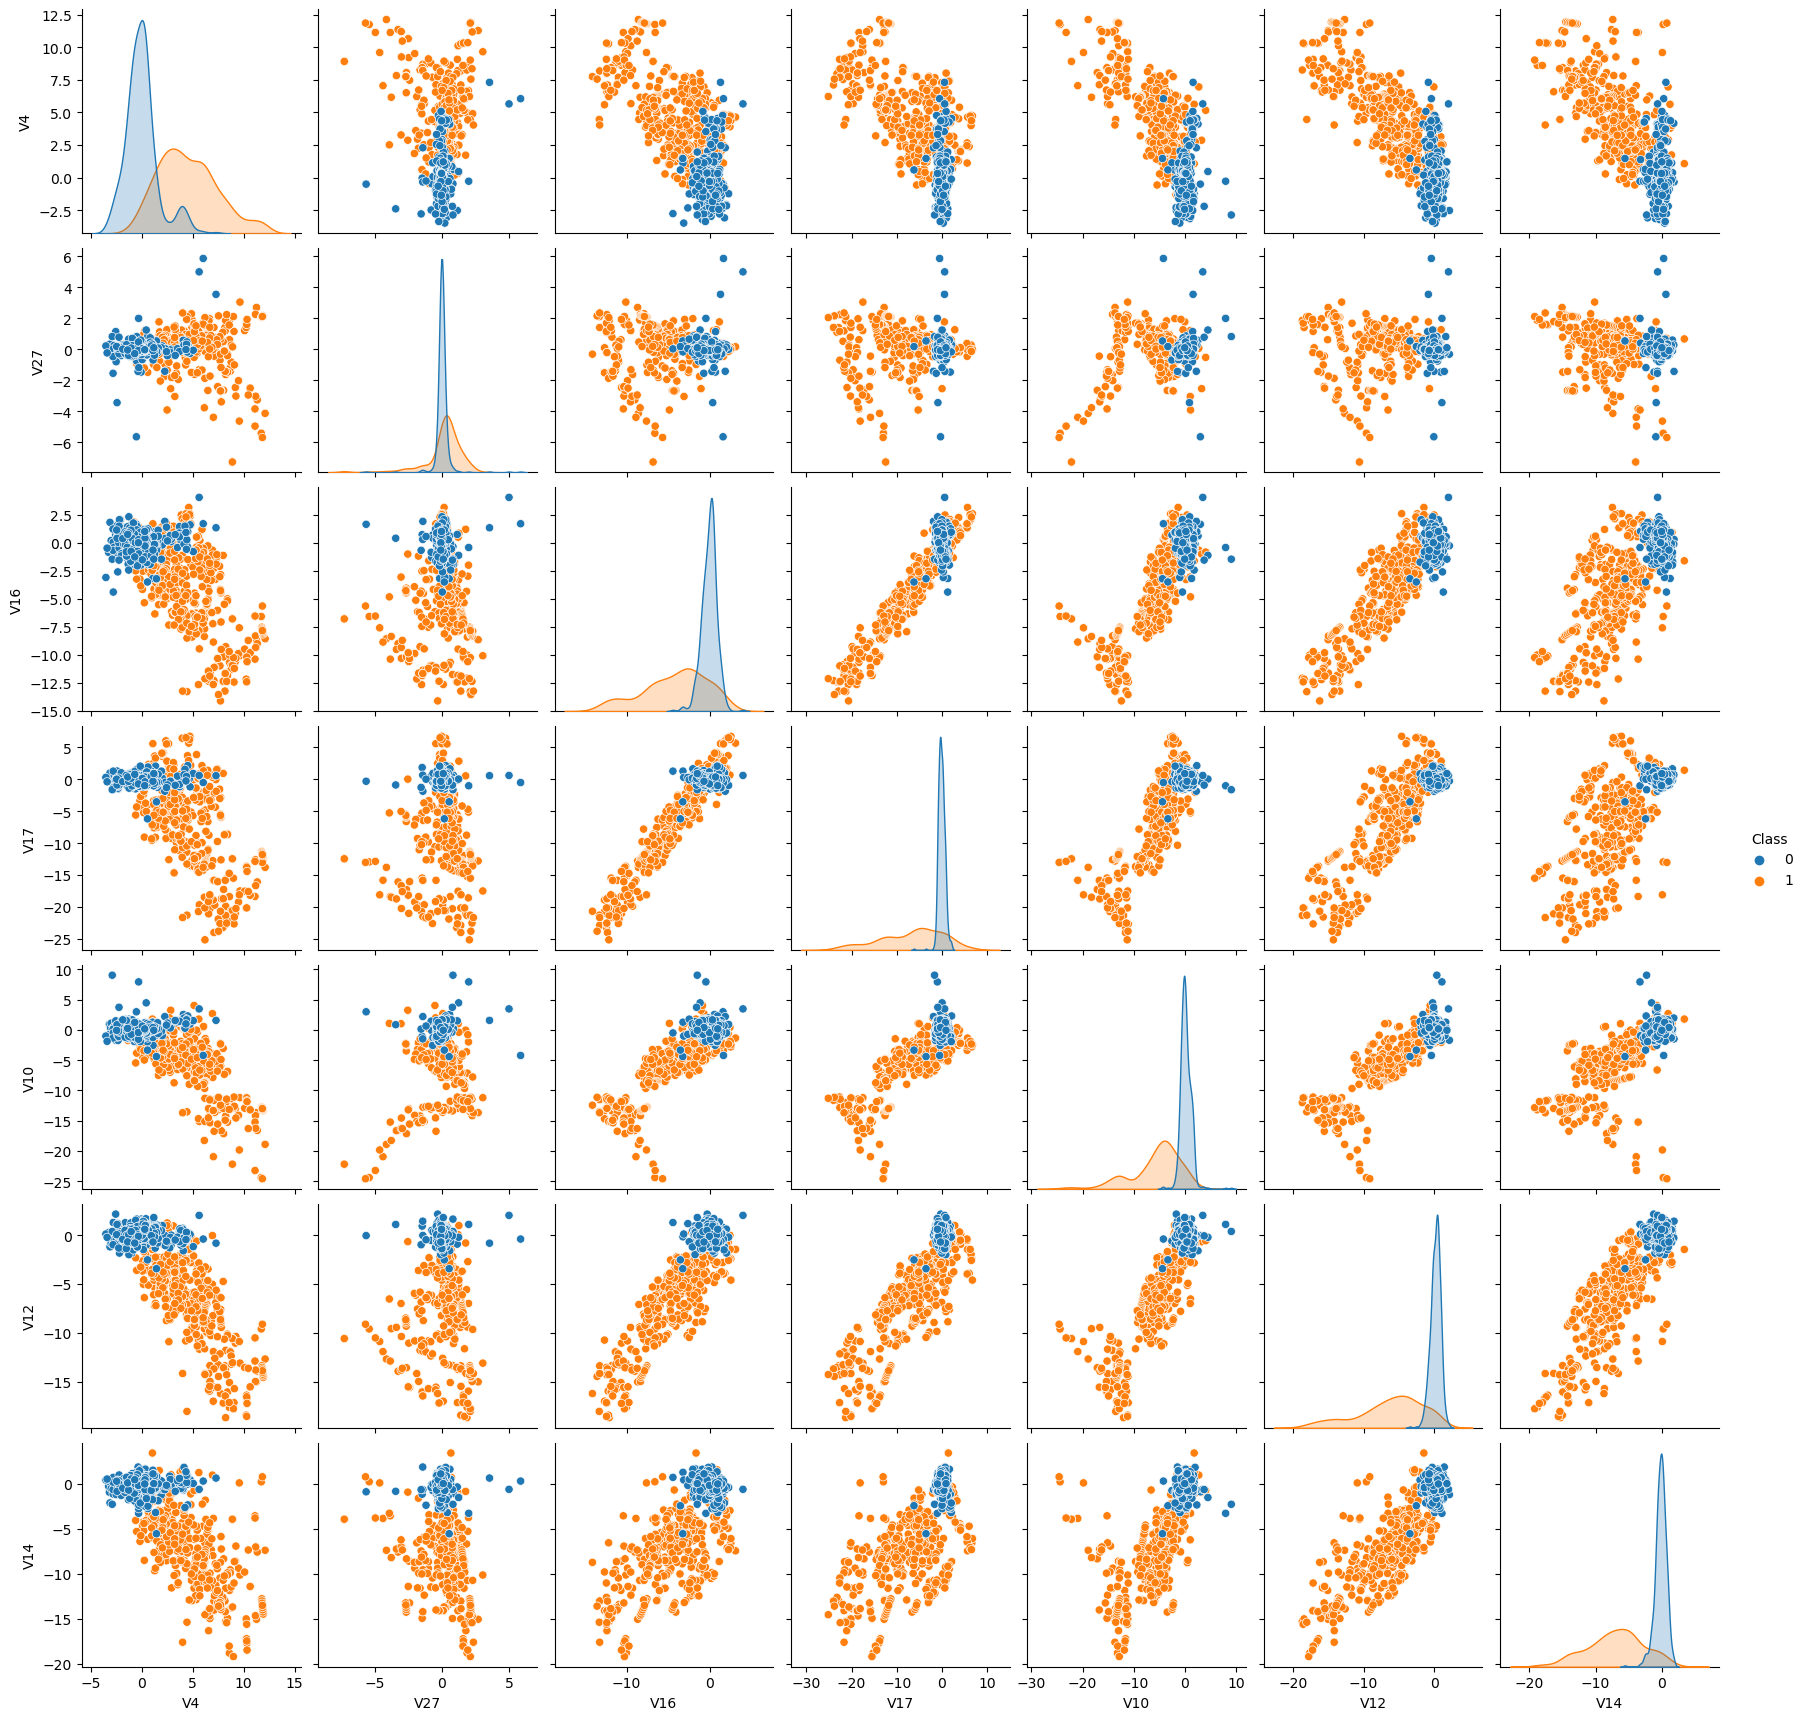

In [18]:
# Pairplot of 1000 rows, ordered by fraud cases
sns.pairplot(selected_data.sort_values('Class', ascending=False).head(1000), hue='Class');

## **5. Feature Engineering**
<hr>
Standardize features to have a mean of 0 and variance of 1.
<hr>

In [19]:
standardizer = StandardScaler()

In [20]:
# Standardize features (X)
X = selected_data.drop('Class', axis=1)
X = standardizer.fit_transform(X)
X

array([[ 0.97336551,  0.33089162, -0.53683287, ...,  0.08338555,
        -0.61829572, -0.32461019],
       [ 0.31652293, -0.02225568,  0.52943375, ..., -0.15334963,
         1.06608857, -0.14998248],
       [ 0.26823129, -0.13713686, -3.29823537, ...,  0.19069961,
         0.06613662, -0.17311389],
       ...,
       [-0.39398367,  0.01103672,  0.1605886 , ..., -0.44522451,
         0.06316942, -0.53265708],
       [ 0.48719238,  0.26960398, -0.69452347, ..., -0.36655778,
        -0.96365742,  0.46904579],
       [-0.35757   , -0.00598394, -0.34535763, ..., -0.84072963,
        -0.0315383 , -0.08795849]])

In [21]:
# Target (y)
y = selected_data['Class']
y = np.array(y)
y

array([0, 0, 0, ..., 0, 0, 0])

### Training and Testing Data
<hr>

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

## **6. Classification Models**
<hr>

1. Logistic Regression

2. Decision Tree

3. Random Forest

4. Naive Bayes

5. Support Vector Machines (SVM)

<hr>

In [23]:
models = {}
times = {}

### **6.1. Logistic Regression** ###
<hr>

Logistic regression uses the logistic function to classify the inputs into two categories and calculate the probability (between 0 and 1) of an input belonging to the default class (class 0).

New inputs are classified based on their calculated probabilities using a decision threshold of 0.5. If the probability is greater than 0.5, we can take the output as a prediction for the default class (class 0), otherwise the prediction is for the other class (class 1).
<hr>

In [24]:
start_time = time.time() # code execution start time

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

end_time = time.time() # code execution end time
# print("Total execution time: {} seconds".format(end_time - start_time))

In [25]:
models['Logistic Regression'] = y_pred_lr
times['Logistic Regression'] = end_time - start_time

### **6.2. Decision Tree** ###
<hr>

Decision tree classification recursively partitions the data based on input features to make predictions. The tree structure consists of nodes representing feature tests and branches representing possible outcomes. 

The goal is to split the data in a way that maximizes the separation of classes (0 or 1) or minimizes prediction errors. New data is classified or predicted by following the path from the root to a leaf node, which provides the final output.

<hr>

In [26]:
start_time = time.time() # code execution start time

# dt = DecisionTreeClassifier(criterion='gini')
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

end_time = time.time() # code execution end time
# print("Total execution time: {} seconds".format(end_time - start_time))

In [27]:
models['Decision Tree'] = y_pred_dt
times['Decision Tree'] = end_time - start_time

### **6.3. Random Forest** ###
<hr>
Random Forest classification assembles multiple decision trees to enhance predictive accuracy. It reduces overfitting by training each tree on different data subsets. The final prediction is a combination of outputs from individual trees, leading to more reliable and accurate results.
<hr>

In [28]:
start_time = time.time() # code execution start time

# rf = RandomForestClassifier(n_estimators=100, min_samples_split=2)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

end_time = time.time() # code execution end time
# print("Total execution time: {} seconds".format(end_time - start_time))

In [29]:
models['Random Forest'] = y_pred_rf
times['Random Forest'] = end_time - start_time

### **6.4. Naive Bayes** ###
<hr>
Naive Bayes is particularly effective for dealing with high-dimensional data because it assumes feature independent. and is based on Bayes' therom, which assumes that input features are independent of each other.

The algorithm calculates class probabilities for based on Bayes' theorem, and assigns the most probable class to an input.
<hr>

In [30]:
start_time = time.time() # code execution start time

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

end_time = time.time() # code execution end time
# print("Total execution time: {} seconds".format(end_time - start_time))

In [31]:
models['Naive Bayes'] = y_pred_nb
times['Naive Bayes'] = end_time - start_time

### **6.5. Support Vector Machines (SVM)** ###
<hr>

Support Vector Machine (SVM) aims to find the optimal boundary that best separates the classes in the data (class 0 and 1) by identifying support vectors, which are data points closest to the decision boundary. 

By utilizing kernel functions, SVM accommodates complex patterns in the data, enabling it to handle both linear and non-linear relationships.

<hr>

In [32]:
start_time = time.time() # code execution start time

svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

end_time = time.time() # code execution end time
# print("Total execution time: {} seconds".format(end_time - start_time))

In [33]:
models['Support Vector Machines'] = y_pred_svm
times['Support Vector Machines'] = end_time - start_time

## **7. Classification Performance**
<hr>
To compare model performance we will look at the following metrics:

1. **Accuracy:** The proportion of correctly classified instances over the total number of instances.

2. **Precision:** The ratio of true positive predictions to the total predicted positives.

3. **Recall:** Also known as Sensitivity or True Positive Rate, it's the ratio of true positive predictions to the total actual positives.

4. **F1-Score:** A single value that balances a model's precision and recall, effectively summarizing its ability to correctly identify positive instances while minimizing false positives and false negatives.

5. **Average Precision Score:** A metric used to evaluate the quality of binary classification models, measuring the average precision of positive class predictions across different levels of classification thresholds.

6. **Runtime (seconds):** The amount of time (in seconds) an algorithm takes to complete its operations. It's a critical performance metric that indicates the efficiency and speed of a process or computation.

<hr>

In [34]:
# Calculate performance metrics
accuracy, precision, recall, f1score, avg_precision, runtime = [], [], [], [], [], []

for i in list(range(0, len(models))):
    accuracy.append(accuracy_score(y_test, list(models.values())[i]))
    precision.append(precision_score(y_test, list(models.values())[i]))
    recall.append(recall_score(y_test, list(models.values())[i]))
    f1score.append(f1_score(y_test, list(models.values())[i]))
    avg_precision.append(average_precision_score(y_test, list(models.values())[i]))
    runtime.append(list(times.values())[i])

In [35]:
# Performance metrics dataframe
metrics = pd.DataFrame([accuracy, precision, recall, f1score, avg_precision, runtime]).T
metrics.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Average Precision Score', 'Runtime']
metrics.index = models.keys()
metrics

,Accuracy,Precision,Recall,F1-Score,Average Precision Score,Runtime
Logistic Regression,0.999075,0.834951,0.581081,0.685259,0.485900,0.541969
Decision Tree,0.999263,0.797203,0.770270,0.783505,0.614460,3.623961
Random Forest,0.999555,0.943548,0.790541,0.860294,0.746276,93.735620
Naive Bayes,0.988706,0.117151,0.844595,0.205761,0.099214,0.080588
Support Vector Machines,0.999380,0.961165,0.668919,0.788845,0.643515,304.543868


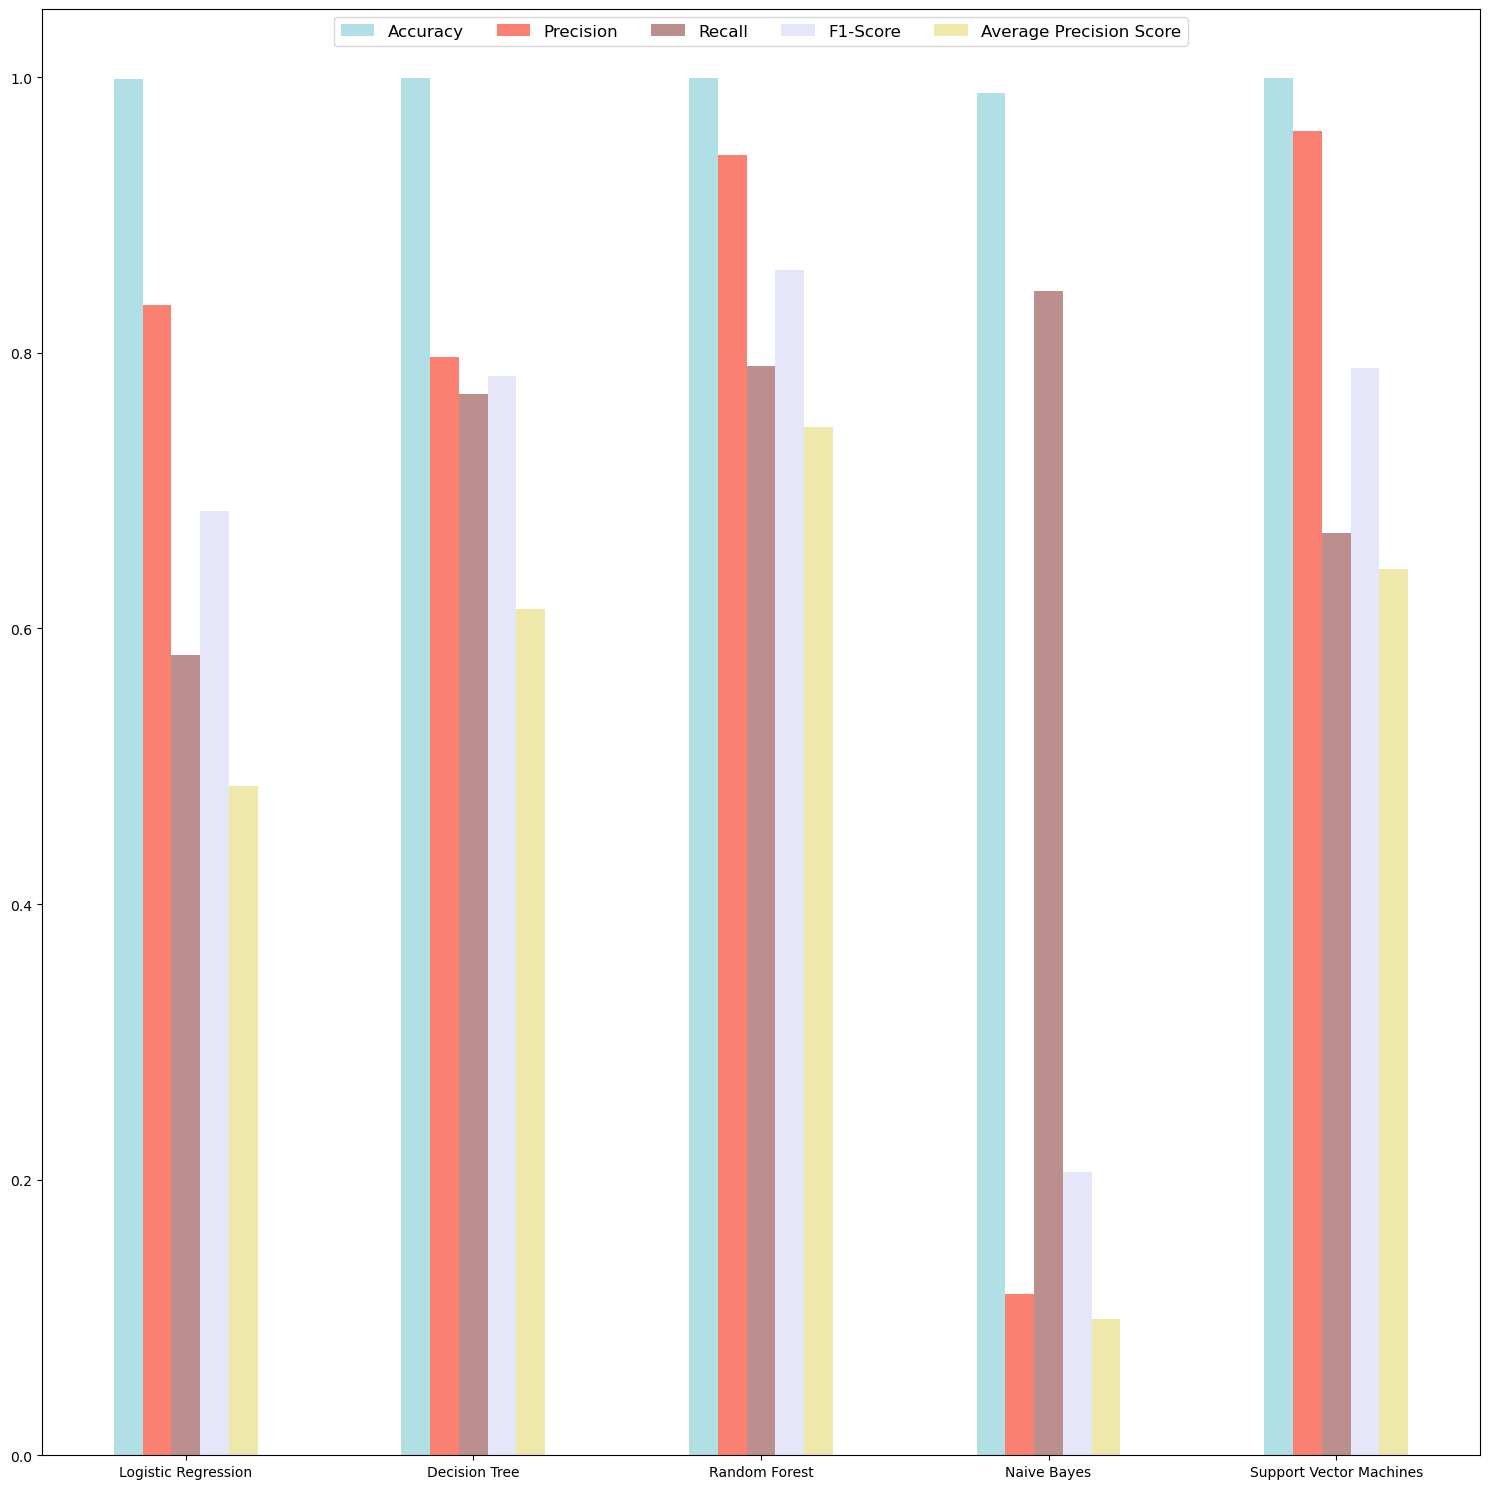

In [36]:
# Performance metrics plot
metrics.drop('Runtime', axis=1).plot.bar(rot=360, color=['powderblue', 'salmon', 'rosybrown', 'lavender', 'palegoldenrod'])
plt.legend(ncol= len(models.keys()), loc='upper center', fontsize=12)
plt.tight_layout();

In [37]:
# Highest Accuracy
print('Highest Accuracy:', metrics['Accuracy'].idxmax(), '= {:.4f}'.format(metrics['Accuracy'].max()))

# Highest Precision
print('Highest Precision:', metrics['Precision'].idxmax(), '= {:.4f}'.format(metrics['Precision'].max()))

# Highest Recall
print('Highest Recall:', metrics['Recall'].idxmax(), '= {:.4f}'.format(metrics['Recall'].max()))

# Highest F1-Score
print('Highest F1-Score:', metrics['F1-Score'].idxmax(), '= {:.4f}'.format(metrics['F1-Score'].max()))

# Highest Average Precision Score
print('Highest Average Precision Score:', metrics['Average Precision Score'].idxmax(), '= {:.4f}'.format(metrics['Average Precision Score'].max()))

# Fastest Runtime 
print('Fastest Runtime:', metrics['Runtime'].idxmax(), '= {:.4f} seconds'.format(metrics['Average Precision Score'].max()))

Highest Accuracy: Random Forest = 0.9996
Highest Precision: Support Vector Machines = 0.9612
Highest Recall: Naive Bayes = 0.8446
Highest F1-Score: Random Forest = 0.8603
Highest Average Precision Score: Random Forest = 0.7463
Fastest Runtime: Support Vector Machines = 0.7463 seconds


## **8. Area Under the Precision-Recall Curve (AUPRC)**
<hr>

Given the class imbalance ratio in the data, we will also look at accuracy using the Area Under the Precision-Recall Curve (AUPRC).

The AUPRC evaluates the quality of binary classification models, and is a graphical representation of the trade-off between precision and recall as the classification threshold varies. A high AUPRC value indicates that the model maintains high precision across different levels of recall, making it effective at correctly identifying positive instances while minimizing false positives.

<hr>

In [38]:
# Calculate AUPRC
auprc = {}

for model_name in metrics.index:
    precision = metrics.loc[model_name, 'Precision']
    recall = metrics.loc[model_name, 'Recall']
    auprc_value = auc(recall, precision) if isinstance(precision, list) else precision
    auprc[model_name] = auprc_value
    
auprc    

{'Logistic Regression': 0.8349514563106796,
 'Decision Tree': 0.7972027972027972,
 'Random Forest': 0.9435483870967742,
 'Naive Bayes': 0.11715089034676664,
 'Support Vector Machines': 0.9611650485436893}

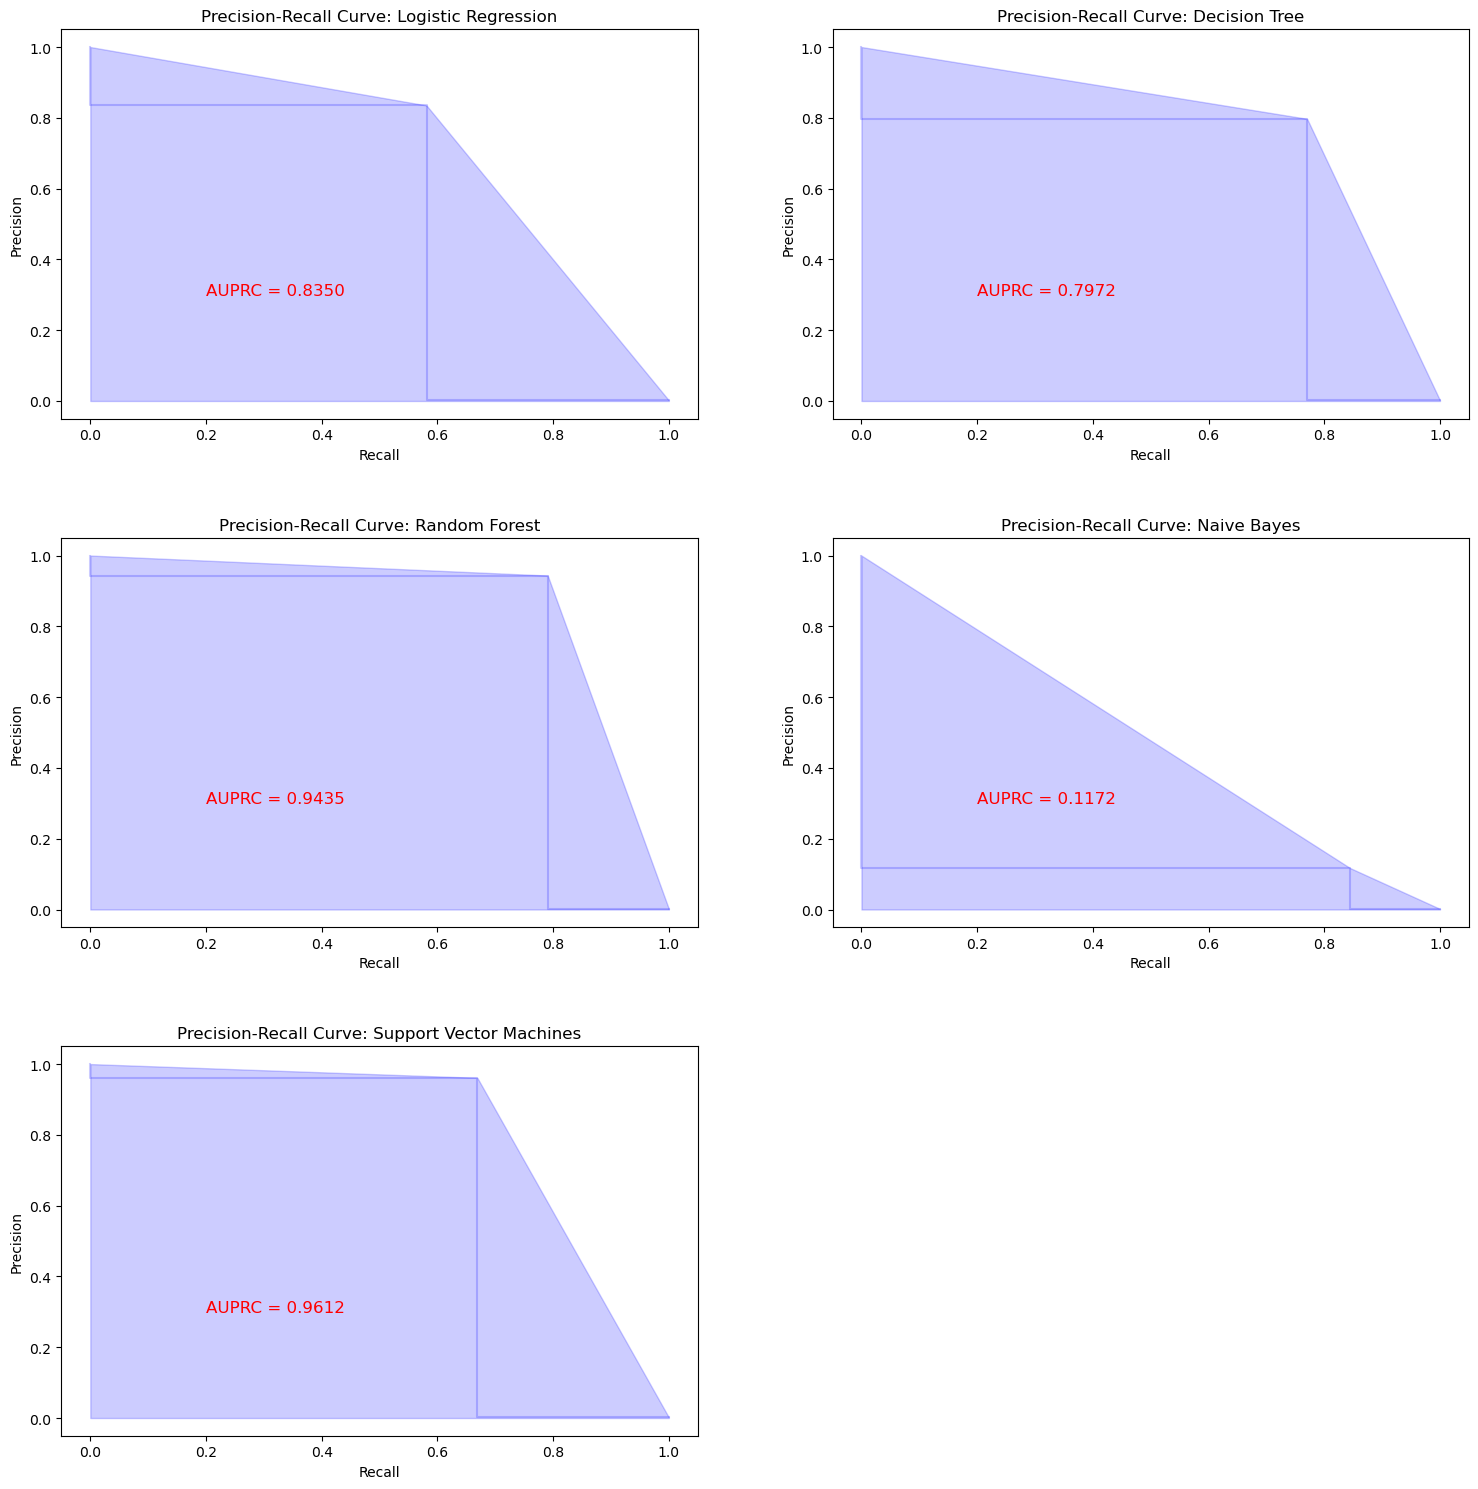

In [39]:
# Plot AUPRC
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
ax = axes.flatten()

for i in list(range(0, len(models))):
    precision, recall, _ = precision_recall_curve(y_test, list(models.values())[i])
    
    ax[i].step(recall, precision, color='b', alpha=0.2, where='post')
    ax[i].fill_between(recall, precision, alpha=0.2, color='b')
    ax[i].set_xlabel('Recall')
    ax[i].set_ylabel('Precision')
    ax[i].set_title('Precision-Recall Curve: ' + list(models.keys())[i])
    ax[i].text(0.2, 0.3, f'AUPRC = {list(auprc.values())[i]:.4f}', fontsize=12, color='red')
fig.tight_layout(w_pad=6, h_pad=4)
fig.delaxes(ax[5])
plt.show()

In [40]:
# Highest AUPRC
print('Highest AUPRC:', max(auprc), '=', '{:.4f}'.format(max(auprc.values())))

Highest AUPRC: Support Vector Machines = 0.9612


## **9. Results and Conclusion**
<hr>

### Results
In summary, we conducted a comprehensive comparison of five supervised classification models — Logistic Regression, Decision Tree, Random Forest, Naive Bayes, and Support Vector Machines (SVM) — for credit card fraud detection. The objective was to identify the most effective model for accurately identifying fraudulent transactions while minimizing false positives.

The performance of each model was evaluated using two critical metrics: the F1-score and the Area Under the Precision-Recall Curve (AUPRC).

The Random Forest model demonstrated the highest F1-score among the evaluated models (0.8603). This suggests that the Random Forest model strikes a balance between precision and recall, making it well-suited for cases where false positives and false negatives carry different consequences. It effectively manages to classify fraudulent transactions while minimizing errors in both directions.

On the other hand, the Support Vector Machines (SVM) model exhibited the highest AUPRC (0.9612). This indicates that the SVM model excels at correctly identifying and ranking fraudulent transactions with high precision. Given the focus on identifying the positive class and the imbalanced nature of fraud detection data, the SVM model's strong AUPRC performance is particularly noteworthy.


### Conclusion
In the realm of credit card fraud detection, accurate identification of fraudulent transactions is of paramount importance, and precision is paramount. False positives can disrupt legitimate transactions and erode user trust. The SVM model's high AUPRC score signifies its ability to identify and rank fraudulent transactions with precision, mitigating the risk of false positives and highliting the model's capability to accurately classify rare instances, such as fraudulent transactions, by concentrating on the positive class and minimizing the chances of misclassification.

Since credit card fraud data is inherently imbalanced, with a vast majority of transactions being legitimate, the SVM model's adeptness at handling such scenarios makes it a pragmatic choice. By emphasizing the positive class, it exhibits the ability to correctly identify rare instances of fraudulent activity in large and noisy data.

In conclusion, the Support Vector Machines (SVM) model stands as the optimal choice for credit card fraud detection. Its robust AUPRC performance, strategic approach to imbalanced data, and holistic solution underscore its suitability for a critical and dynamic domain.
<hr>

<hr>
<hr>

#### [GitHub Project Repository](https://github.com/yevi7113/Supervised-Learning-Project/tree/main)